In [12]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import anndata
from scipy.stats import spearmanr, pearsonr
import numpy as np
from PIL import Image
import matplotlib

from digitalhistopathology.benchmark.benchmark_clustering import BenchmarkClustering

# Load configuration
with open("../../config/config_notebooks_TNBC_with_HER2_model.json", "r") as config_file:
    config = json.load(config_file)

Image.MAX_IMAGE_PIXELS = None
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

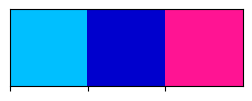

In [13]:
a = config["retrained_color_palette"]
sns.palplot(sns.color_palette(a))

In [14]:
extension='pdf'



In [15]:
# This will give you the results for the FULL models.

model_type = config["retrained_model_list2_type"]
model_list = config["retrained_model_list2"]
benchmark_folder = config["retrained_benchmark_folder2"]
path_to_pipeline=config['path_to_retrained_pipelines_2']


# UNCOMMENT TO GENERATE THE RESULTS FOR THE EXPLORA MODELS
# model_type = config["retrained_model_list1_type"]
# model_list = config["retrained_model_list1"]
# benchmark_folder = config["retrained_benchmark_folder1"]
# path_to_pipeline=config['path_to_retrained_pipelines_1']


pairs_to_compare = [("uni", model) for model in model_list if model != "uni"]

models_palette = dict(zip(model_list, a))
models_palette["handcrafted_features"] = "lightgrey"


In [16]:

saving_folder=os.path.join(benchmark_folder, "unsupervised_clustering_ARI", "kmeans")

benchmark_clustering = BenchmarkClustering(path_to_pipeline=path_to_pipeline,
                                           pipelines_list=model_list,
                                           results_folder="../../results",
                                           saving_folder=saving_folder,
                                           dataset=config['dataset'],
                                           extension=extension
                                           )

['uni', 'uni_full_koleo_4096_prototypes', 'HER2_uni_full_koleo_16384_prototypes']
<class 'list'>
Label files: []


In [17]:
def plot_ari_scores_all_patients(clustering_dict, model_list=None):

    if model_list is None:
        model_list = clustering_dict.keys()

    ari_scores = {}
    for model in model_list:
        ari_scores[model] = {}
        for patient in clustering_dict[model].keys():
            if (patient != 'all') and (patient != 'mean'):
                ari_scores[model][patient] = clustering_dict[model][patient]['ari']
    df_aris = pd.DataFrame.from_dict(ari_scores)
    df_aris_melted = pd.melt(df_aris, var_name='model', value_name='ari')
    df_aris_melted['patient'] = df_aris.index.to_list()*len(df_aris.columns)

    sns.boxplot(data=df_aris_melted, x='model', y='ari', color='white', linewidth=2)
    sns.stripplot(data=df_aris_melted, x='model', y='ari', jitter=True, dodge=True, linewidth=1, hue='patient', palette='Accent')
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    plt.title('ARI scores for unsupervised clustering', weight='bold')

## Comparison between linear and unlinear clustering

In [18]:

raw_clust = benchmark_clustering.unsupervised_clustering_benchmark(n_clusters=None, clustering_name='raw')


svd_clust = benchmark_clustering.unsupervised_clustering_benchmark(n_clusters=None, clustering_name='svd5')
    

umap_clust = benchmark_clustering.get_best_UMAP_ari_per_slide(force_loading=True)


Loading unsupervised clustering results for model uni...
Loading unsupervised clustering results for model uni_full_koleo_4096_prototypes...
Loading unsupervised clustering results for model HER2_uni_full_koleo_16384_prototypes...
Loading unsupervised clustering results for model uni...
Loading unsupervised clustering results for model uni_full_koleo_4096_prototypes...
Loading unsupervised clustering results for model HER2_uni_full_koleo_16384_prototypes...
Embeddings per patient: None
Loading unsupervised clustering results for model uni_full_koleo_4096_prototypes...
Loading unsupervised clustering results for model HER2_uni_full_koleo_16384_prototypes...
Loading unsupervised clustering results for model uni...
Loading unsupervised clustering results for model uni_full_koleo_4096_prototypes...
Loading unsupervised clustering results for model HER2_uni_full_koleo_16384_prototypes...
Embeddings per patient: None
Force loading best UMAP parameters for model uni_full_koleo_4096_prototypes

In [19]:
for model in raw_clust.keys():
    print(f"Model: {model}: ari all: {raw_clust[model]['all']['ari']}, ari mean: {raw_clust[model]['mean']['ari']}")

Model: uni: ari all: 0.24181559049465756, ari mean: 0.3353989381110288
Model: uni_full_koleo_4096_prototypes: ari all: 0.17605929209144505, ari mean: 0.26376430035595777
Model: HER2_uni_full_koleo_16384_prototypes: ari all: 0.24538262211132564, ari mean: 0.40137143623538657


In [20]:
for model in raw_clust.keys():
    print(f"Model: {model}: ari tumor: {raw_clust[model]['ARI_tumor']}")

Model: uni: ari tumor: 0.01924608024415077
Model: uni_full_koleo_4096_prototypes: ari tumor: 0.020921702776216536
Model: HER2_uni_full_koleo_16384_prototypes: ari tumor: 0.011669442744879702


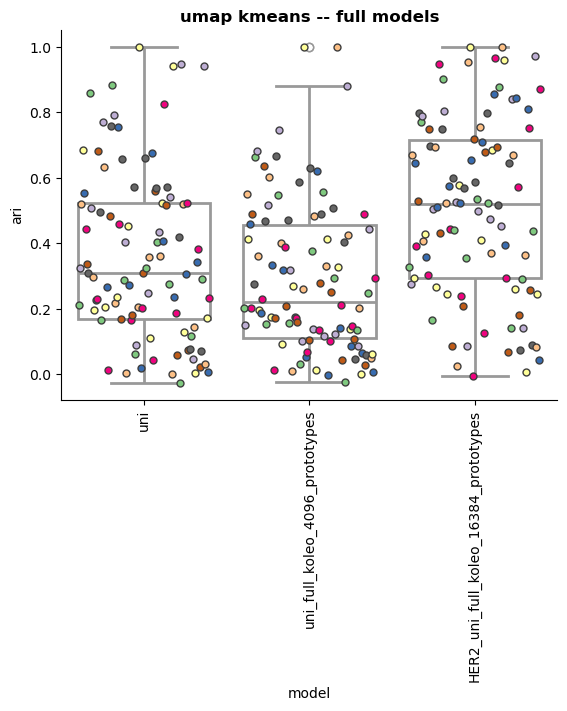

In [21]:
# for clust_dict, clust_name in zip([raw_clust, svd_clust, umap_clust], ["raw", "svd", "umap"]):

plt.figure()
plot_ari_scores_all_patients(umap_clust, model_list=model_list)
plt.title(f"umap kmeans -- {model_type} models", weight='bold')

if len(umap_clust[model_list[0]].keys()) > 15:
    plt.legend().remove()

plt.savefig(os.path.join(config['figures_folder'], f"Figure3/umap_kmeans_all_patients_{model_type}_models.{extension}"), bbox_inches='tight', dpi=300)



In [22]:
# Scatter plot

In [23]:
dfs_clust = []
for clustering_dict, method in zip([raw_clust, svd_clust, umap_clust], ["raw", "svd", "umap"]):
#for clustering_dict, method in zip([umap_clust], ["umap"]):
    ari_scores = {}
    for model in clustering_dict.keys():
        ari_scores[model] = {}
        for patient in clustering_dict[model].keys():
            #if (patient != 'all') and (patient != 'mean'):
            if (patient != 'ARI_tumor'):
                ari_scores[model][patient] = clustering_dict[model][patient]['ari']
    df_aris = pd.DataFrame.from_dict(ari_scores)
    df_aris_melted = pd.melt(df_aris, var_name='model', value_name='ari')
    df_aris_melted['patient'] = df_aris.index.to_list()*len(df_aris.columns)
    df_aris_melted['clustering'] = method
    dfs_clust.append(df_aris_melted)

df_comp = pd.concat(dfs_clust)




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


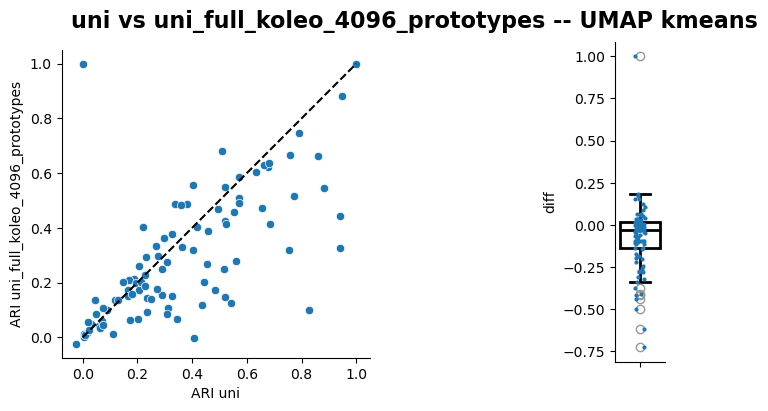

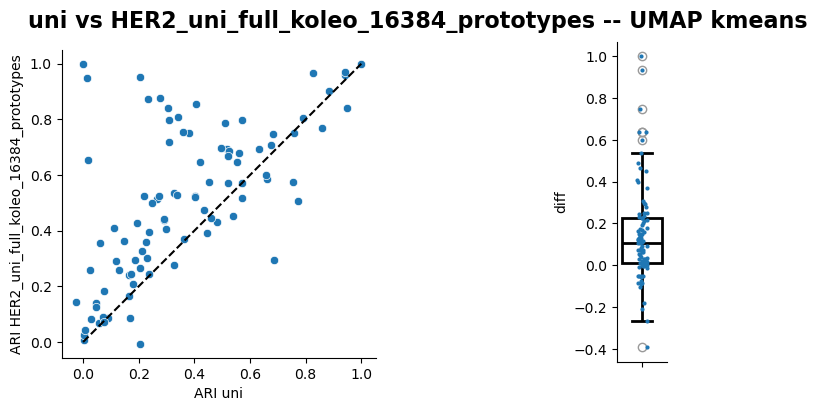

In [24]:
df_comps = {}
for clust_type in ['umap']:
  df_comps[clust_type] = {}
  for pair in pairs_to_compare:
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)

    df_sub_comp = df_comp[(df_comp['model'] == pair[1]) 
                            & (df_comp['clustering'] == clust_type) 
                            & (df_comp['patient'] != 'mean') 
                            & (df_comp['patient'] != 'all')].merge(df_comp[(df_comp['model'] == pair[0]) 
                                                                        & (df_comp['clustering'] == clust_type) 
                                                                        & (df_comp['patient'] != 'mean') 
                                                                        & (df_comp['patient'] != 'all')], 
                                                                        left_on='patient',
                                                                            right_on='patient', 
                                                                            suffixes=(f'_{pair[1]}', f'_{pair[0]}'))
    
    df_comps[clust_type][f"{pair[1]}"] = df_sub_comp
    
    plt.gca().set_aspect('equal', adjustable='box')
    sns.scatterplot(data=df_sub_comp, x=f'ari_{pair[0]}', y=f'ari_{pair[1]}')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    if len(df_sub_comp['patient'].unique()) > 15:
      plt.legend().remove()
    else:
      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # plt.title(f'{pair[0]} vs {pair[1]}', weight='bold')
    plt.xlabel(f'ARI {pair[0]}')
    plt.ylabel(f'ARI {pair[1]}')
    sns.despine()

    df_sub_comp['diff'] = df_sub_comp[f'ari_{pair[1]}'] - df_sub_comp[f'ari_{pair[0]}']

    # plt.title(f'Difference in ARI {pair[1]} - {pair[0]}', weight='bold')

    plt.subplot(1, 2, 2)
    plt.gca().set_position([0.7, 0.1, 0.05, 0.8])
    sns.boxplot(data=df_sub_comp, y='diff', color='white', linewidth=2,  boxprops=dict(facecolor='white', edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'))
    sns.stripplot(data=df_sub_comp, y='diff', linewidth=0, size=3)
    
    if len(df_sub_comp['patient'].unique()) > 15:
      plt.legend().remove()
    else:
      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()

    plt.suptitle(f'{pair[0]} vs {pair[1]} -- {clust_type.upper()} kmeans', weight='bold', fontsize=16)
    plt.savefig(os.path.join(config["figures_folder"], f"Figure3/{pair[0]}_vs_{pair[1]}_{clust_type}_kmeans.pdf"), bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


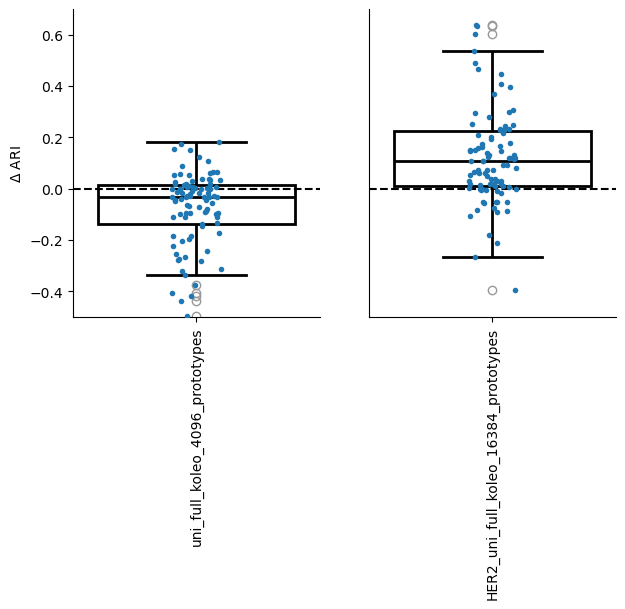

In [26]:
plt.figure(figsize=(7, 4))

df_comps = {}
for clust_type in ['umap']:
  df_comps[clust_type] = {}
  for i, pair in enumerate(pairs_to_compare):
    
    plt.subplot(1, len(pairs_to_compare), i+1)

    df_sub_comp = df_comp[(df_comp['model'] == pair[1]) 
                            & (df_comp['clustering'] == clust_type) 
                            & (df_comp['patient'] != 'mean') 
                            & (df_comp['patient'] != 'all')].merge(df_comp[(df_comp['model'] == pair[0]) 
                                                                        & (df_comp['clustering'] == clust_type) 
                                                                        & (df_comp['patient'] != 'mean') 
                                                                        & (df_comp['patient'] != 'all')], 
                                                                        left_on='patient',
                                                                            right_on='patient', 
                                                                            suffixes=(f'_{pair[1]}', f'_{pair[0]}'))
    
    df_comps[clust_type][f"{pair[1]}"] = df_sub_comp
    


    df_sub_comp['diff'] = df_sub_comp[f'ari_{pair[1]}'] - df_sub_comp[f'ari_{pair[0]}']

    #plt.gca().set_position([0.7, 0.1, 0.05, 0.8])
    sns.boxplot(data=df_sub_comp, y='diff', color='white', linewidth=2,  boxprops=dict(facecolor='white', edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'))
    sns.stripplot(data=df_sub_comp, y='diff', linewidth=0, size=4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    plt.xticks(ticks=[0], labels=[pair[1]], rotation=90)
    plt.ylim(-0.5, 0.7)
    
    plt.axhline(0, color='black', linestyle='--')
    plt.ylabel(r'$\Delta$ ARI')
    if i != 0:

        plt.gca().axes.get_yaxis().set_visible(False)
    
    if i != len(pairs_to_compare) -1:
        plt.legend().remove()
        
    if len(df_sub_comp['patient'].unique()) > 15:
      plt.legend().remove()
    else:
      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        

plt.savefig(os.path.join(config["figures_folder"], f"Figure3/boxplot_ARI_differences_per_patient_{clust_type}_kmeans_{model_type}_models.pdf"), bbox_inches='tight')


In [27]:
df_comp_patient = df_comp[~(df_comp["patient"].isin(["mean", "all"]))]


In [28]:
df_comp[df_comp['clustering'] == 'raw'][['model', 'ari']].groupby('model').mean()

,ari
model,
HER2_uni_full_koleo_16384_prototypes,0.399747
uni,0.334424
uni_full_koleo_4096_prototypes,0.262851


In [29]:
df_comp[df_comp['clustering'] == 'raw'][['model', 'ari']].groupby('model').std()

,ari
model,
HER2_uni_full_koleo_16384_prototypes,0.263123
uni,0.257511
uni_full_koleo_4096_prototypes,0.215573


In [30]:

for value in df_comp[df_comp['clustering'] == 'umap'][['model', 'ari']].groupby('model').std().loc[model_list, 'ari']:
    print(f"{value:.2f}")


0.26
0.23
0.27


In [32]:
df_comp_patient

,model,ari,patient,clustering
0,uni,0.401375,TNBC1_CN1_C1,raw
1,uni,0.514197,TNBC2_CN1_E1,raw
2,uni,0.168349,TNBC3_CN2_C1,raw
3,uni,0.824906,TNBC4_CN2_D2,raw
4,uni,0.328768,TNBC5_CN3_D1,raw
...,...,...,...,...
465,uni2,0.122341,TNBC16_CN8_E2,umap
466,uni2,0.161080,TNBC3_CN2_C1,umap
467,uni2,0.558145,TNBC62_CN31_D2,umap
468,uni2,0.717774,TNBC14_CN7_D2,umap


In [36]:
df_comp = df_comp[df_comp['model'] != "uni2"]


In [50]:
df_comp_patient[df_comp_patient['clustering'] == 'umap']

,model,ari,patient,clustering
0,uni_full_koleo_4096_prototypes,0.666635,TNBC27_CN14_C2,umap
1,uni_full_koleo_4096_prototypes,0.171935,TNBC57_CN29_C2,umap
2,uni_full_koleo_4096_prototypes,0.508651,TNBC2_CN1_E1,umap
3,uni_full_koleo_4096_prototypes,0.091230,TNBC89_CN45_C2,umap
4,uni_full_koleo_4096_prototypes,0.603802,TNBC84_CN42_E1,umap
...,...,...,...,...
371,handcrafted_features,0.036523,TNBC16_CN8_E2,umap
372,handcrafted_features,0.054390,TNBC3_CN2_C1,umap
373,handcrafted_features,0.325013,TNBC62_CN31_D2,umap
374,handcrafted_features,0.536008,TNBC14_CN7_D2,umap


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


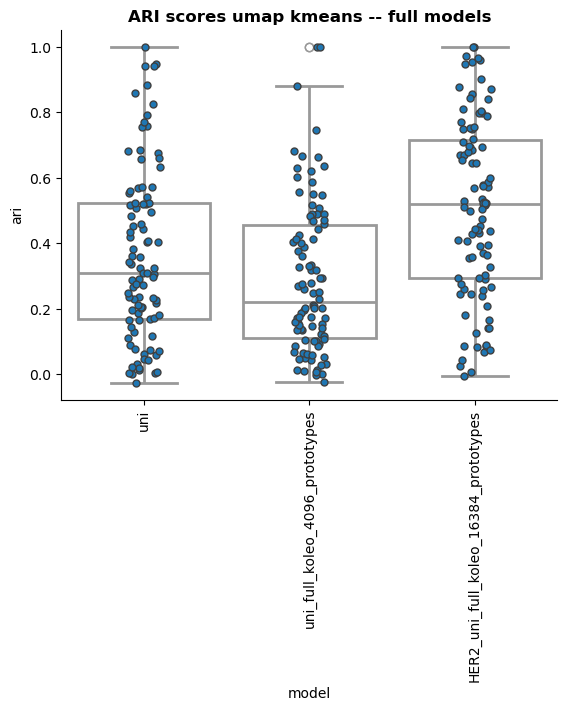

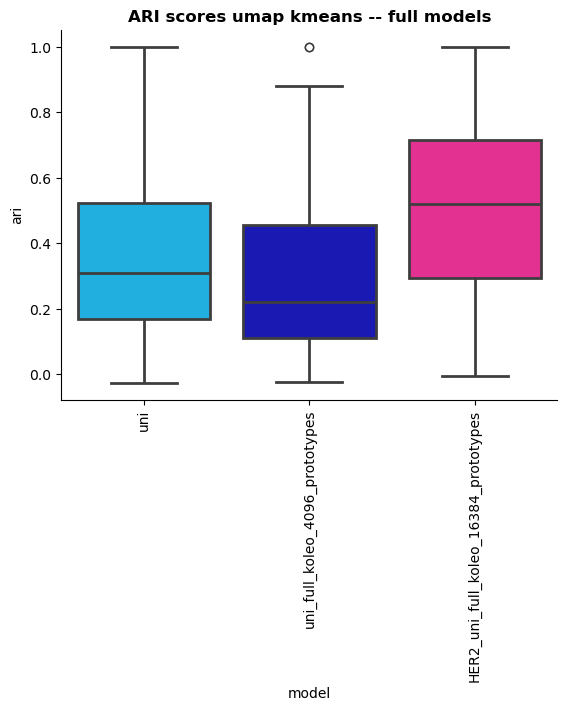

In [53]:
## 
df_comp_patient = df_comp_patient[df_comp_patient['model'] != 'uni2']
sns.boxplot(data=df_comp_patient[df_comp_patient['clustering'] == 'umap'], 
            x='model', y='ari', color='white', linewidth=2, order=config["retrained_model_list2"])
sns.stripplot(data=df_comp_patient[df_comp_patient['clustering'] == 'umap'], 
              x='model', y='ari', jitter=True, dodge=True, linewidth=1, order=config["retrained_model_list2"])
plt.xticks(rotation=90)
sns.despine()
plt.title('ARI scores for unsupervised clustering', weight='bold')
sns.despine()
plt.title(f"ARI scores umap kmeans -- {model_type} models", weight='bold')

if len(df_comp_patient['patient'].unique()) > 15:
    plt.legend().remove()
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/ari_scores_umap_kmeans_{model_type}_models_with_patient.pdf"), bbox_inches='tight')

## 
plt.figure()
sns.boxplot(data=df_comp_patient[df_comp_patient['clustering'] == 'umap'], 
            x='model', y='ari', hue='model', linewidth=2, palette=models_palette, 
            order=config["retrained_model_list2"])
plt.xticks(rotation=90)
sns.despine()
plt.title('ARI scores for unsupervised clustering', weight='bold')
sns.despine()
plt.title(f"ARI scores umap kmeans -- {model_type} models", weight='bold')


if len(df_comp_patient['patient'].unique()) > 15:
    plt.legend().remove()
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/ari_scores_umap_kmeans_{model_type}_models_colors.pdf"), bbox_inches='tight')

In [38]:

for i, model in enumerate(df_comp['model'].unique()):
    print(model)
    sub_df = df_comp[(df_comp['model'] == model) & (df_comp['clustering'] == 'umap')][['ari', 'patient']].rename(columns = {'ari': model})
    # dfs.append(sub_df)
    if i > 0:
        df = df.merge(sub_df, on='patient')
    else:
        df = sub_df.copy()

df.set_index('patient', inplace=True)
df_delta_ari = df.apply(lambda x: x - df['uni'])
df_delta_ari.drop('uni', axis=1, inplace=True) 

uni
uni_full_koleo_4096_prototypes
HER2_uni_full_koleo_16384_prototypes
handcrafted_features


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-0.3, 0.7)

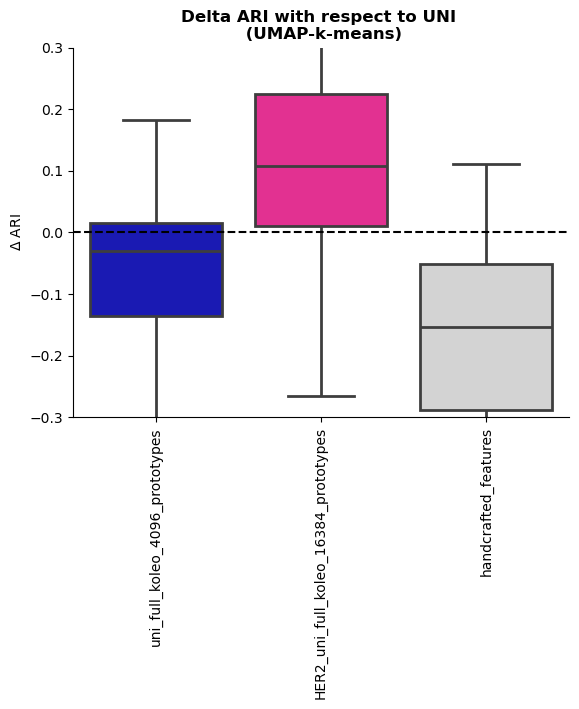

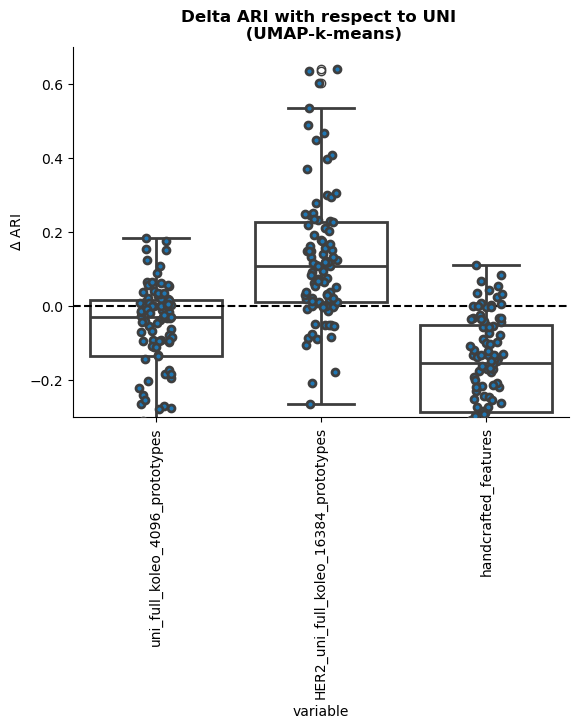

In [41]:
# plot delta ARI
plt.figure()
sns.boxplot(data=df_delta_ari, palette=models_palette, linewidth=2, showfliers=False)
plt.title(f'Delta ARI with respect to UNI \n (UMAP-k-means)', weight='bold')
plt.ylabel(r'$\Delta$ ARI')
sns.despine()
plt.xticks(rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/delta_umap_ari_scores_boxplot_{model_type}_models_colors.pdf"), bbox_inches='tight')
plt.ylim(-0.3, 0.3)

plt.figure()
sns.boxplot(data=df_delta_ari, color='white', linewidth=2)

# sns.stripplot(data=df_delta_ari.reset_index(), palette='Accent', hue='index')
df_long = df_delta_ari.reset_index().melt(id_vars=['patient'], var_name='variable', value_name='value')

# Create the strip plot
sns.stripplot(data=df_long, x='variable', y='value', jitter=True, dodge=True, linewidth=2)
plt.title(f'Delta ARI with respect to UNI \n (UMAP-k-means)', weight='bold')
plt.ylabel(r'$\Delta$ ARI')
sns.despine()
plt.xticks(rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/delta_umap_ari_scores_boxplot_{model_type}_models_with_patient.pdf"), bbox_inches='tight')

if df_long['patient'].nunique() > 15:
    plt.legend().remove()
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    
plt.ylim(-0.3, 0.7)

In [42]:
## Correlation with shannon entropy
import json 

with open(os.path.join(benchmark_folder, "shannon_entropy", "shannon_entropy_all_comps_raw.json")) as f:
    shannon_entropy = json.load(f)

In [43]:
os.path.join(benchmark_folder, "shannon_entropy", "shannon_entropy_all_comps_raw.json")

'../../results/TNBC/benchmark/HER2_full_models/shannon_entropy/shannon_entropy_all_comps_raw.json'

In [44]:
df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])


In [45]:
df_shannon.rename(index={'handcrafted': 'handcrafted_features'}, inplace=True)

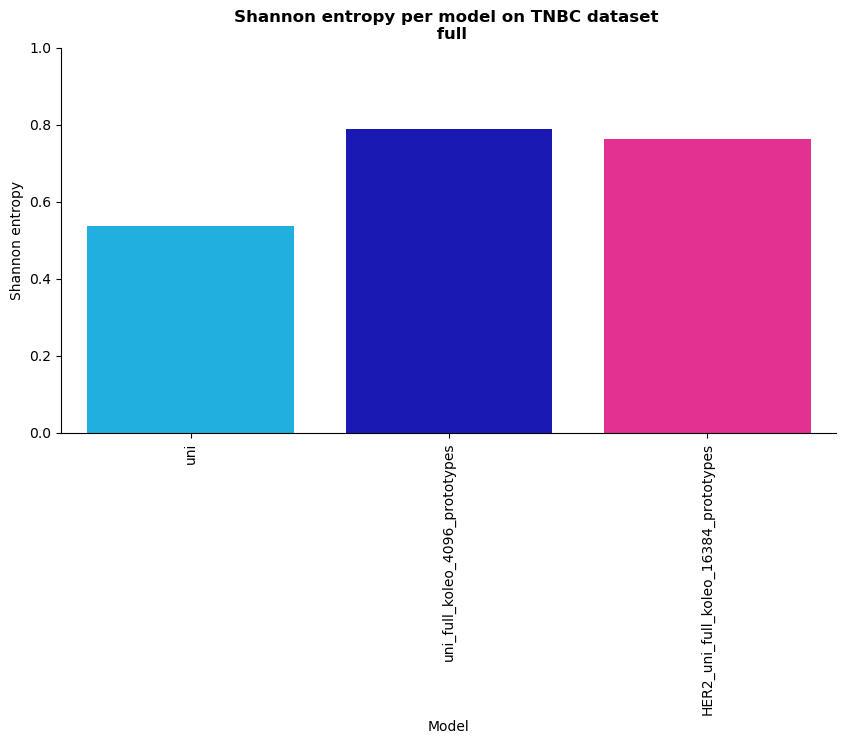

In [46]:
# df_shannon.sort_values('shannon_entropy', inplace=True, ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=df_shannon, 
            x=df_shannon.index, 
            y='shannon_entropy', 
            hue=df_shannon.index, palette=models_palette)
sns.despine()
plt.xlabel("Model")
plt.ylabel("Shannon entropy")
plt.title(f"Shannon entropy per model on {config['dataset']} dataset \n {model_type}", weight='bold')
plt.xticks(rotation=90)
plt.ylim(0,1)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/shannon_entropy_per_model_{model_type}.pdf"), bbox_inches='tight')

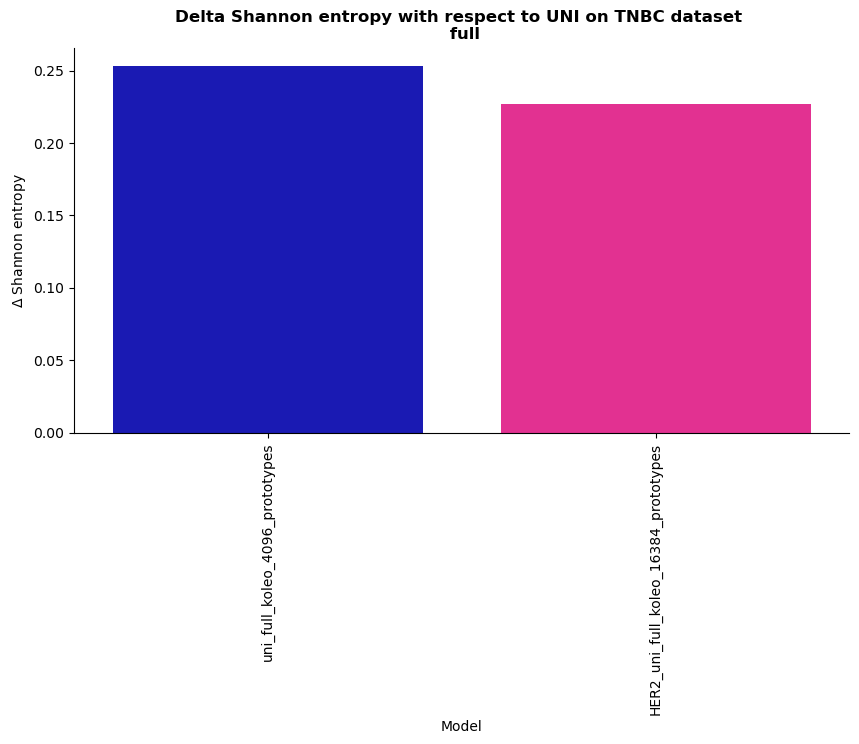

In [47]:
df_shannon_delta = df_shannon.copy()
df_shannon_delta = df_shannon_delta - df_shannon.loc['uni']
df_shannon_delta.drop('uni', inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_shannon_delta, 
            x=df_shannon_delta.index, 
            y='shannon_entropy', 
            hue=df_shannon_delta.index, palette=models_palette)
sns.despine()
plt.xlabel("Model")
plt.ylabel(r"$\Delta$ Shannon entropy")
plt.title(f"Delta Shannon entropy with respect to UNI on {config['dataset']} dataset \n {model_type}", weight='bold')
plt.xticks(rotation=90)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/delta_shannon_entropy_per_model_{model_type}_barplot.pdf"), bbox_inches='tight')



